In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean
import mol2graph
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [2]:
plt.style.use("ggplot")

In [3]:
train_mols = [m for m in Chem.SDMolSupplier('solubility.train.sdf')]
test_mols = [m for m in Chem.SDMolSupplier('solubility.test.sdf')]
sol_cls_dict = {'(A) low':0, '(B) medium':1, '(C) high':2}
print(len(train_mols), len(test_mols))
print(train_mols[0].GetPropsAsDict())

1025 257
{'ID': 1, 'NAME': 'n-pentane', 'SOL': -3.18, 'SOL_classification': '(A) low', 'smiles': 'CCCCC'}


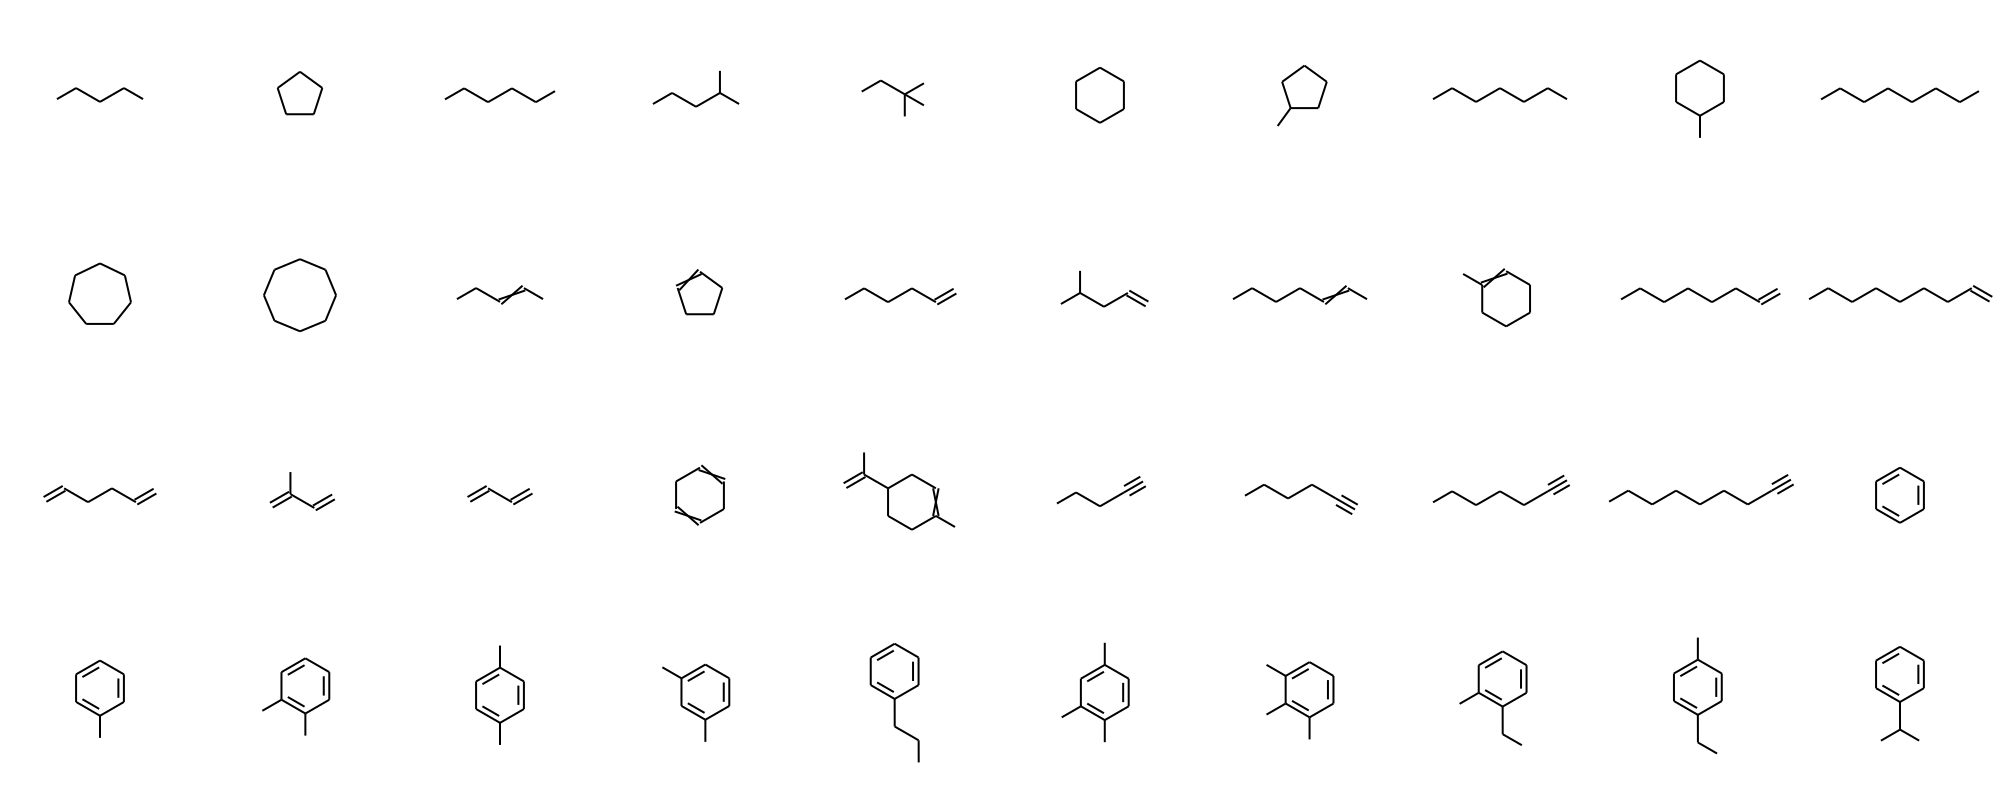

In [4]:
Draw.MolsToGridImage(train_mols[:40], molsPerRow=10)

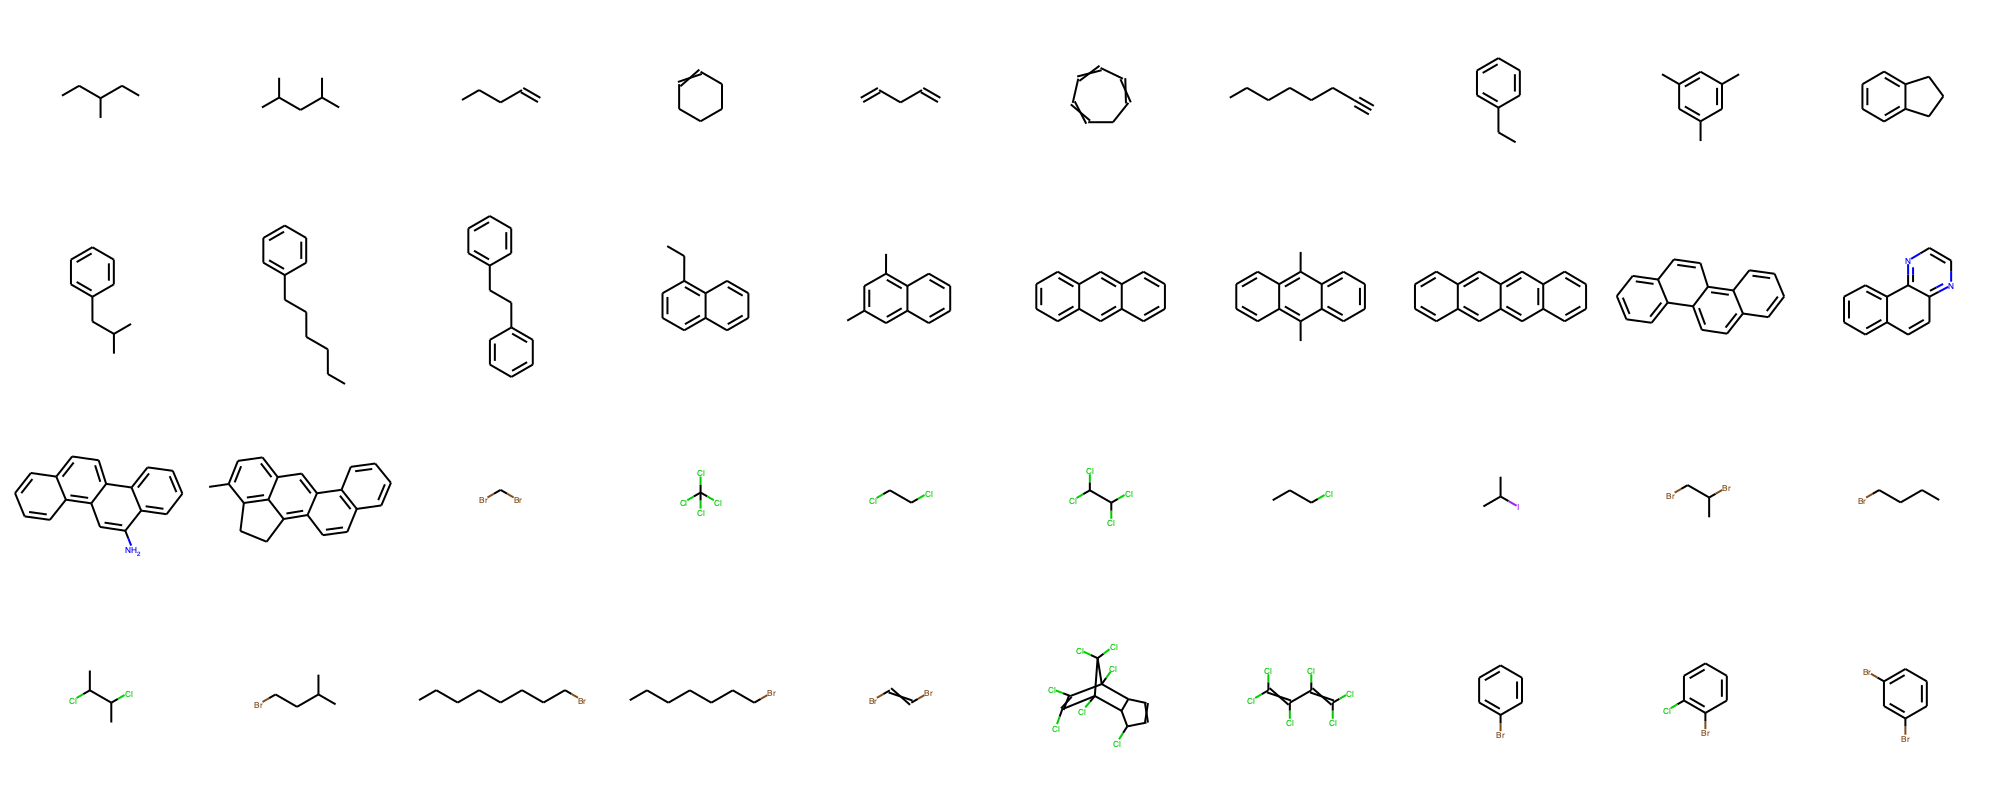

In [5]:
Draw.MolsToGridImage(test_mols[:40], molsPerRow=10)

In [6]:
train_X = [mol2graph.mol2vec(m) for m in train_mols]
for i, data in enumerate(train_X):
    y = sol_cls_dict[train_mols[i].GetProp('SOL_classification')]
    data.y = torch.tensor([y], dtype=torch.long)

test_X = [mol2graph.mol2vec(m) for m in test_mols]
for i, data in enumerate(test_X):
    y = sol_cls_dict[test_mols[i].GetProp('SOL_classification')]
    data.y = torch.tensor([y], dtype=torch.long)

In [7]:
train_loader = DataLoader(train_X, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_X, batch_size=64, shuffle=True, drop_last=True)

In [8]:
n_features = 75

In [9]:
# definenet
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(n_features, 128, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(128)
        self.conv2 = GCNConv(128, 64, cached=False)
        self.bn2 = BatchNorm1d(64)
        self.fc1 = Linear(64, 64)
        self.bn3 = BatchNorm1d(64)
        self.fc2 = Linear(64, 64)
        self.fc3 = Linear(64, 3)
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = global_add_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x        

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [11]:
print(model)

Net(
  (conv1): GCNConv(75, 128)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(128, 64)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)


In [12]:
def train(epoch):
    model.train()
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_X)

In [13]:
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [14]:
hist = {"loss":[], "acc":[], "test_acc":[]}
for epoch in range(1, 101):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    hist["loss"].append(train_loss)
    hist["acc"].append(train_acc)
    hist["test_acc"].append(test_acc)
    print(f'Epoch: {epoch}, Train loss: {train_loss:.3}, Train_acc: {train_acc:.3}, Test_acc: {test_acc:.3}')

Epoch: 1, Train loss: 0.833, Train_acc: 0.58, Test_acc: 0.611
Epoch: 2, Train loss: 0.665, Train_acc: 0.663, Test_acc: 0.685
Epoch: 3, Train loss: 0.547, Train_acc: 0.783, Test_acc: 0.767
Epoch: 4, Train loss: 0.474, Train_acc: 0.774, Test_acc: 0.747
Epoch: 5, Train loss: 0.458, Train_acc: 0.826, Test_acc: 0.79
Epoch: 6, Train loss: 0.424, Train_acc: 0.825, Test_acc: 0.774
Epoch: 7, Train loss: 0.408, Train_acc: 0.722, Test_acc: 0.677
Epoch: 8, Train loss: 0.448, Train_acc: 0.84, Test_acc: 0.794
Epoch: 9, Train loss: 0.377, Train_acc: 0.823, Test_acc: 0.798
Epoch: 10, Train loss: 0.369, Train_acc: 0.858, Test_acc: 0.798
Epoch: 11, Train loss: 0.388, Train_acc: 0.861, Test_acc: 0.813
Epoch: 12, Train loss: 0.428, Train_acc: 0.812, Test_acc: 0.755
Epoch: 13, Train loss: 0.4, Train_acc: 0.815, Test_acc: 0.786
Epoch: 14, Train loss: 0.368, Train_acc: 0.822, Test_acc: 0.767
Epoch: 15, Train loss: 0.339, Train_acc: 0.861, Test_acc: 0.786
Epoch: 16, Train loss: 0.366, Train_acc: 0.825, Test_a

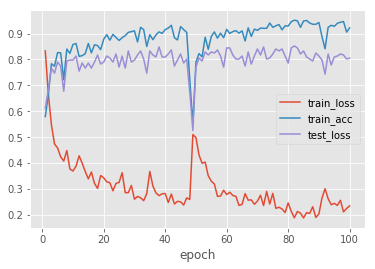

In [15]:
ax = plt.subplot(1,1,1)
ax.plot([e for e in range(1,101)], hist["loss"], label="train_loss")
ax.plot([e for e in range(1,101)], hist["acc"], label="train_acc")
ax.plot([e for e in range(1,101)], hist["test_acc"], label="test_loss")
plt.xlabel("epoch")
ax.legend()

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from rdkit.Chem import DataStructs

In [17]:
train_fps = [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in train_mols]
test_fps =  [AllChem.GetMorganFingerprintAsBitVect(mol,2) for mol in test_mols]

In [18]:
train_X = []
for fp in train_fps:
    arr = np.zeros(0,)
    DataStructs.ConvertToNumpyArray(fp, arr)
    train_X.append(arr)
train_X = np.asarray(train_X)
train_Y = [sol_cls_dict[train_mols[i].GetProp('SOL_classification')] for i in range(len(train_mols))]

test_X = []
for fp in test_fps:
    arr = np.zeros(0,)
    DataStructs.ConvertToNumpyArray(fp, arr)
    test_X.append(arr)
test_X = np.asarray(test_X)
test_Y = [sol_cls_dict[test_mols[i].GetProp('SOL_classification')] for i in range(len(test_mols))]


In [19]:
rfc = RandomForestClassifier()

In [20]:
rfc.fit(train_X, train_Y)

/Users/iwatobipen/.pyenv/versions/anaconda3-5.1.0/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
pred = rfc.predict(test_X)

In [22]:
print(classification_report(test_Y, pred))

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       102
           1       0.66      0.62      0.64       115
           2       0.62      0.60      0.61        40

   micro avg       0.67      0.67      0.67       257
   macro avg       0.66      0.66      0.66       257
weighted avg       0.67      0.67      0.67       257



In [23]:
print(accuracy_score(test_Y, pred))

0.6731517509727627
